In [80]:
from  skimage import data
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.feature import hessian_matrix

plt.rcParams['text.color'] = 'w'
plt.rcParams['xtick.color'] = 'w'
plt.rcParams['ytick.color'] = 'w'
plt.rcParams['axes.labelcolor'] = 'w'
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}
from IPython.display import Image

from skimage import transform, io
from scipy.ndimage import maximum_filter,minimum_filter
from scipy.ndimage import gaussian_filter

In [81]:
def zero_out_edges(img):
    img[0,:,:] = False
    img[:,0,:] = False
    img[img.shape[0]-1,:,:] = False
    img[:,img.shape[1]-1,:] = False

    return img

def return_dog_extremas(img, im_scale, sigmas):

    img_rescaled = transform.rescale(img,im_scale)

    imgs_blured  = np.zeros(shape=(img_rescaled.shape[0], img_rescaled.shape[1], 5))
    for i, sigma in zip(range(len(sigmas)),sigmas):
        imgs_blured[:,:, i]  = gaussian_filter(img_rescaled,sigma)

    difference_of_gaussians = np.zeros(shape=(img_rescaled.shape[0], img_rescaled.shape[1], 4))
    for i in range(len(sigmas)-1):
        difference_of_gaussians[:,:,i] = imgs_blured[:,:,i]-imgs_blured[:,:,i+1]
    dog_max_filt = maximum_filter(difference_of_gaussians,(3,3,3))
    dog_min_filt = minimum_filter(difference_of_gaussians,(3,3,3))

    local_max = (difference_of_gaussians==dog_max_filt)
    local_min = (difference_of_gaussians==dog_min_filt)

    key_points_candidates = np.logical_or(np.sum(local_max[:,:,1:3],axis=2)>0, np.sum(local_min[:,:,1:3],axis=2)>0)

    return transform.resize(key_points_candidates, output_shape=(img.shape[0],img.shape[1]))

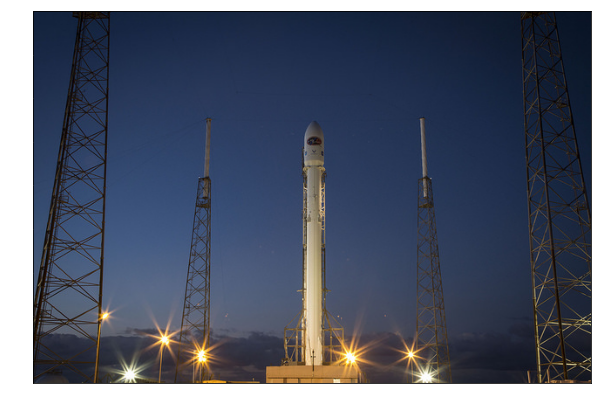

In [82]:
from skimage.morphology import binary_dilation,rectangle
sigmas = [1.6,  np.sqrt(2)*1.6, 2*1.6, np.sqrt(2)*2*1.6]
#img_orig = io.imread("img/PIA24429-Perseverance's_Big_Wheel .png")
img_orig = data.rocket()
img  = rgb2gray(img_orig)
plt.figure(figsize=(10,10))
plt.imshow(img_orig)

Text(0.5, 1.0, 'Detected key points of Octave at native resolution')

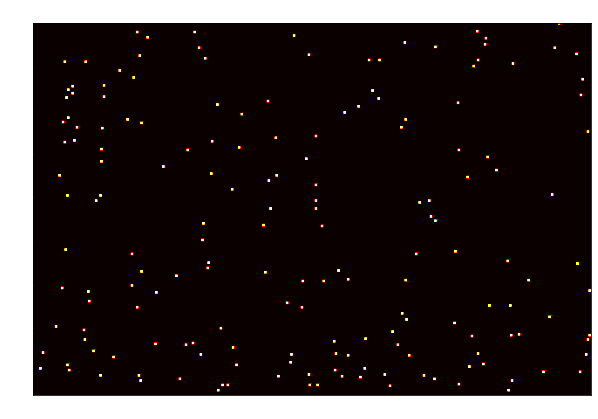

In [83]:
imgs_blured  = np.zeros(shape=(img.shape[0], img.shape[1], len(sigmas)))
for i, sigma in zip(range(len(sigmas)),sigmas):
    imgs_blured[:,:, i]  = gaussian_filter(img,sigma)

difference_of_gaussians = np.zeros(shape=(img.shape[0], img.shape[1], len(sigmas)-1))
for i in range(len(sigmas)-1):
    difference_of_gaussians[:,:,i] = imgs_blured[:,:,i]-imgs_blured[:,:,i+1]
dog_max_filt = maximum_filter(difference_of_gaussians,(3,3,3))
dog_min_filt = minimum_filter(difference_of_gaussians,(3,3,3))

local_max = (difference_of_gaussians==dog_max_filt)
local_min = (difference_of_gaussians==dog_min_filt)
key_points_candidates = zero_out_edges(np.logical_or(local_max[:,:,1:2], local_min[:,:,1:2]))

plt.figure(figsize=(10,10))
plt.imshow(binary_dilation(key_points_candidates[:,:,0],selem=rectangle(3,3)))
plt.title("Detected key points of Octave at native resolution")


https://medium.com/@russmislam/implementing-sift-in-python-a-complete-guide-part-1-306a99b50aa5

In [85]:
from numpy import linalg
x,y = np.where(key_points_candidates[:,:,0])
#for x,y in zip(x,y):
    #box = difference_of_gaussians[x-:x+2,y,:]
    #hessian = computeGradientAtCenterPixel()
    #gradient = computeHessianAtCenterPixel()
    #extremum_update = -linalg.lstsq(hessian, gradient, rcond=None)[0]


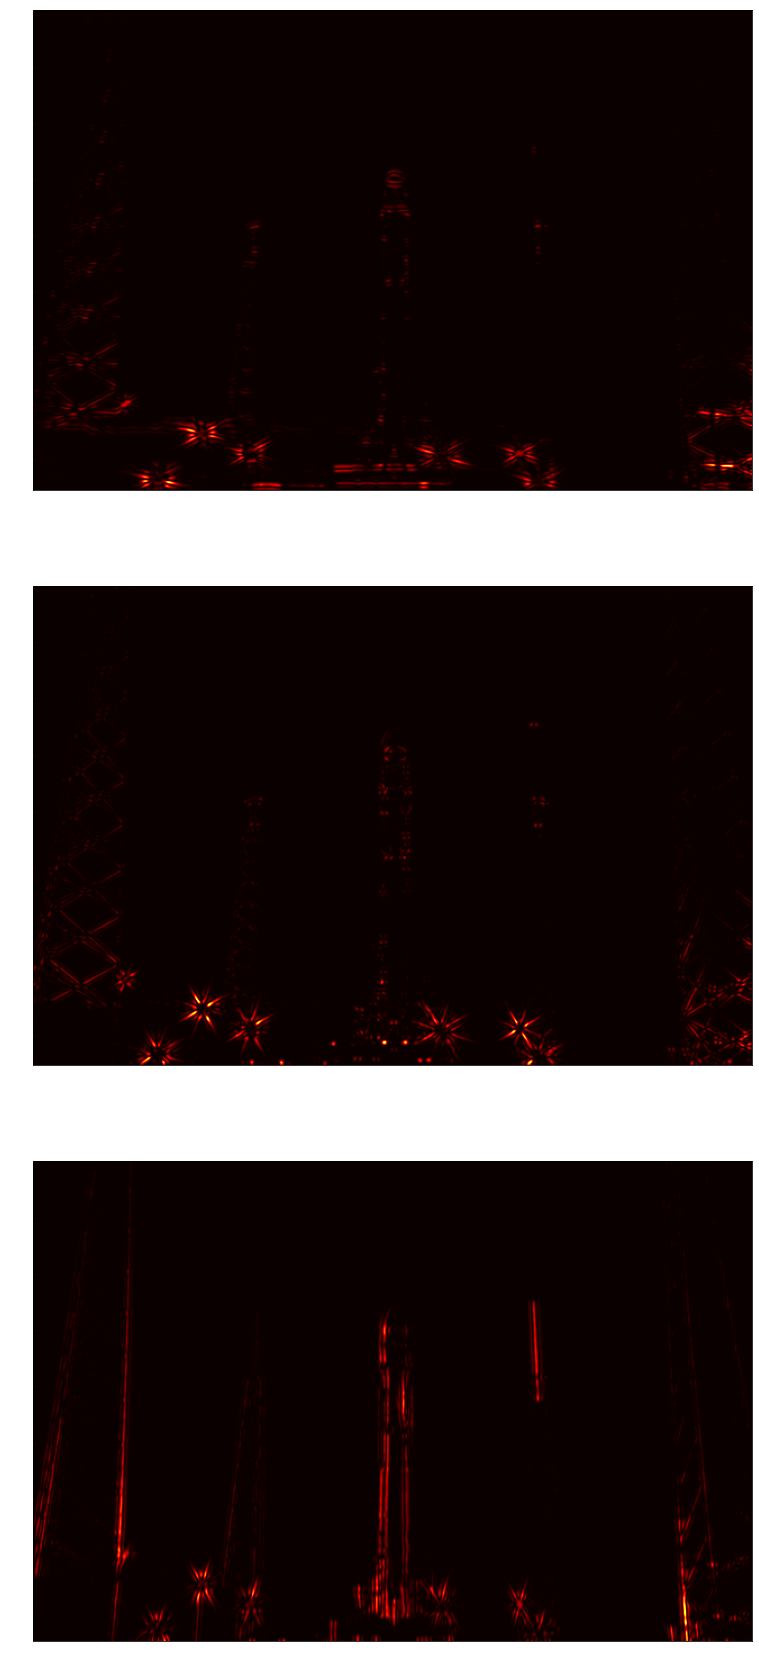

In [120]:
Hxx, Hxy, Hyy = hessian_matrix(imgs_blured[:,:, 0], sigma=0, order='xy')

plt.figure(figsize=(20,30))
plt.subplot(311)
plt.set_cmap('hot')
plt.imshow(Hxx**2)
plt.subplot(312)
plt.imshow(Hxy**2)
plt.subplot(313)
plt.imshow(Hyy**2)

In [122]:
Trace_H = Hxx+Hyy
Det_H = Hxx*Hyy- Hxy**2
principal_curv_ratio  = Trace_H**2 /Det_H

r = 10 # paper recommendation
removed_edge_points  = principal_curv_ratio < ((r+1)**2)/r

<ipython-input-122-9a34dc576075>:3: RuntimeWarning: divide by zero encountered in true_divide
  principal_curv_ratio  = Trace_H**2 /Det_H


In [88]:
contrast_threshold = np.abs(difference_of_gaussians[:,:,1:2])>0.03 # paper recommneded

Original candidates from one sigma from native resolution octave: 176
Contrastpoints: 154. Points remaining: 22
Edge removed Contrast removed points: 4. Points remaining: 18


Text(0.5, 1.0, 'Removed non corners')

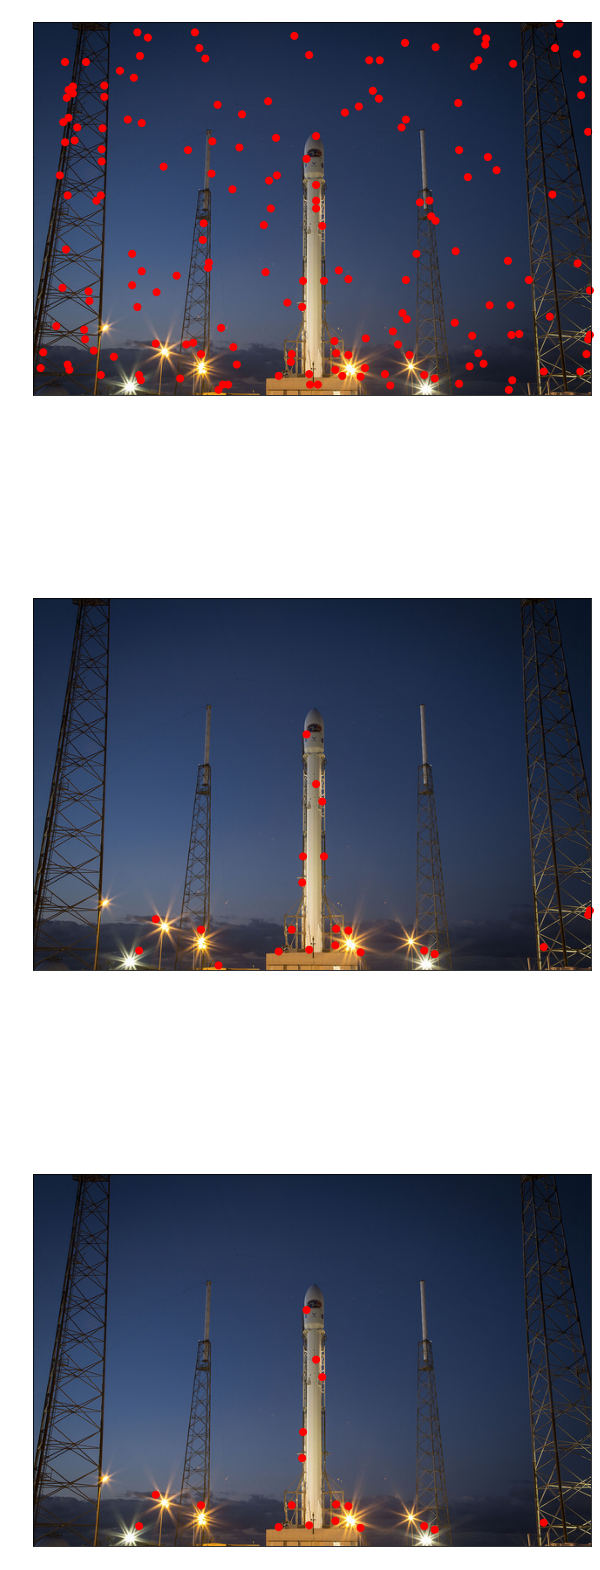

In [89]:
print("Original candidates from one sigma from native resolution octave: {}".format(np.sum(key_points_candidates[:,:,0])))

good_keypoints  = np.logical_and(key_points_candidates[:,:,0],contrast_threshold[:,:,0] )
print("Contrastpoints: {}. Points remaining: {}".format(np.sum(key_points_candidates[:,:,0]) - np.sum(good_keypoints),
                                                             np.sum(good_keypoints)))

even_better_keypoints = np.logical_and(good_keypoints,removed_edge_points)
print("Edge removed Contrast removed points: {}. Points remaining: {}".format(np.sum(good_keypoints) - np.sum(even_better_keypoints),
                                                             np.sum(even_better_keypoints)))

plt.figure(figsize=(10,30))
ax = plt.subplot(311)
rr, cc = np.where(key_points_candidates[:,:,0])
ax.imshow(img_orig)
for r,c in zip(rr,cc):
    circle1 = plt.Circle((c, r), 4, color='r', clip_on=False)
    ax.add_patch(circle1)
plt.title("Orginal proposal")


ax = plt.subplot(312)
rr, cc = np.where(good_keypoints)
ax.imshow(img_orig)
for r,c in zip(rr,cc):
    circle1 = plt.Circle((c, r), 4, color='r', clip_on=False)
    ax.add_patch(circle1)
plt.title("Removed low contrast")


ax = plt.subplot(313)

rr, cc = np.where(even_better_keypoints)
ax.imshow(img_orig)
for r,c in zip(rr,cc):
    circle1 = plt.Circle((c, r), 4, color='r', clip_on=False)
    ax.add_patch(circle1)
plt.title("Removed non corners")

https://aishack.in/tutorials/sift-scale-invariant-feature-transform-keypoint-orientation/

Text(0.5, 1.0, 'Orientation')

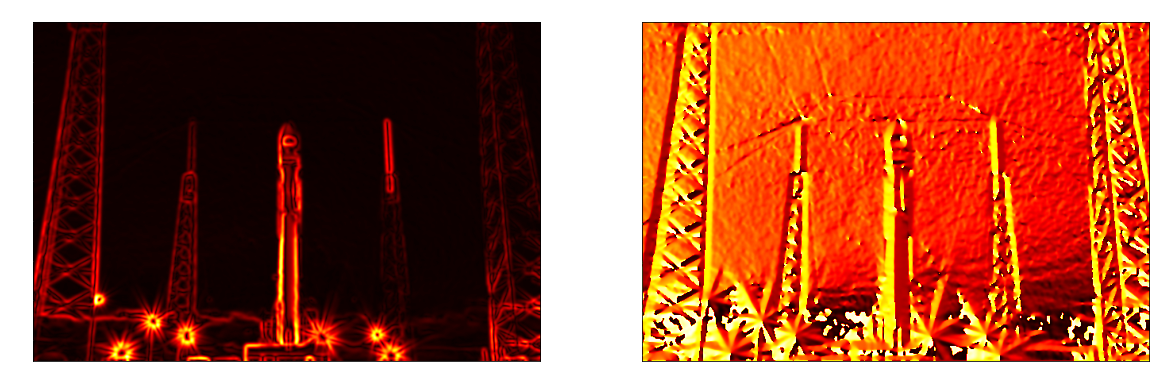

In [90]:
L = imgs_blured[...,1]

dLdx = np.pad((L[1:L.shape[0],:] - L[0:L.shape[0]-1,:]),((0,1),(0,0)),mode='constant', constant_values=(0, 0))
dLdy = np.pad((L[:,1:L.shape[1]] - L[:,0:L.shape[1]-1]),((0,0),(1,0)),mode='constant', constant_values=(0, 0))

mag  = np.sqrt(dLdx **2 + dLdy **2)
orientation  = np.arctan2(dLdy,dLdx)
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(mag)
plt.title("Magnitude")
plt.subplot(122)
plt.imshow(orientation)
plt.title("Orientation")

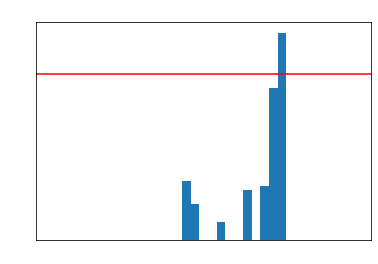

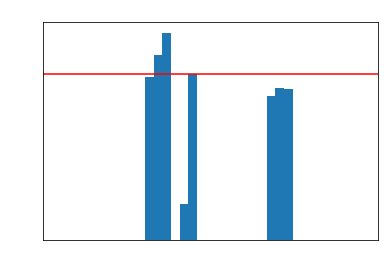

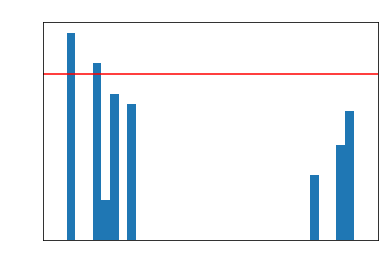

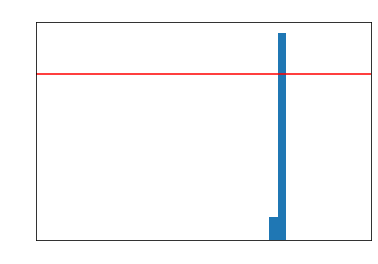

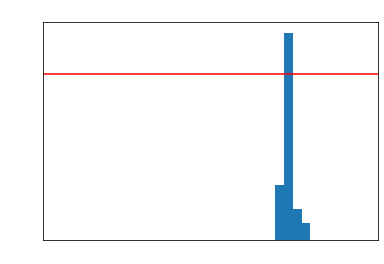

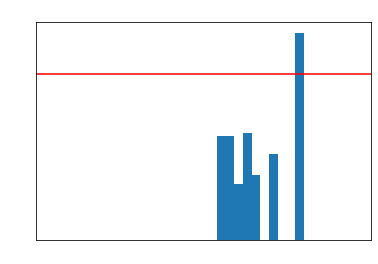

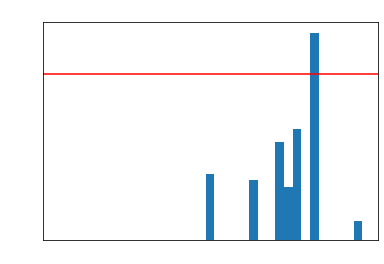

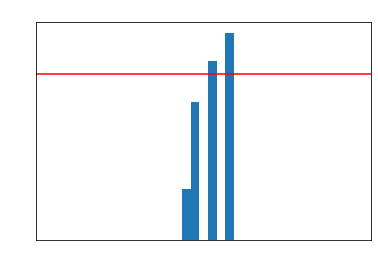

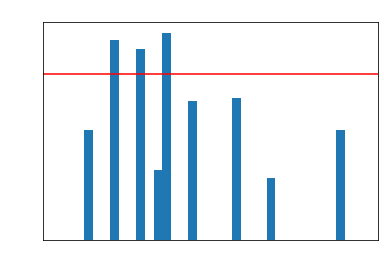

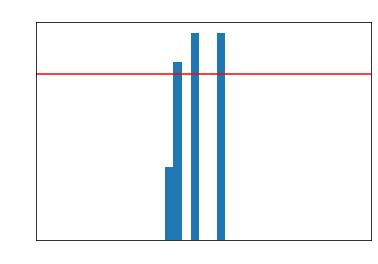

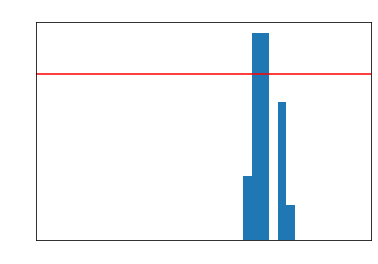

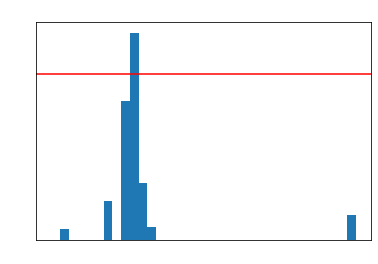

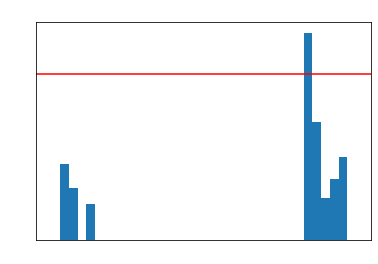

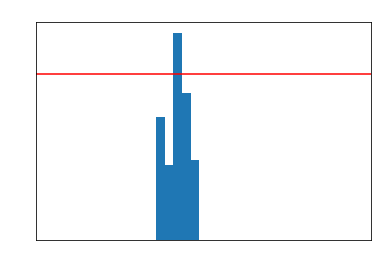

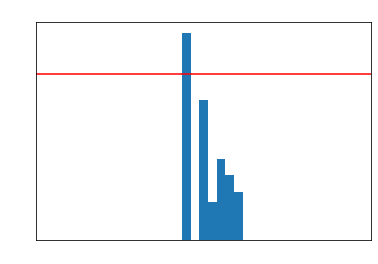

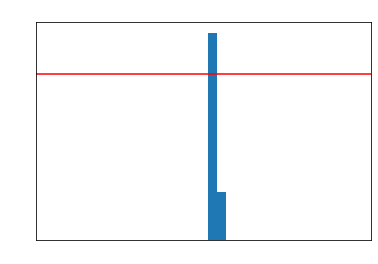

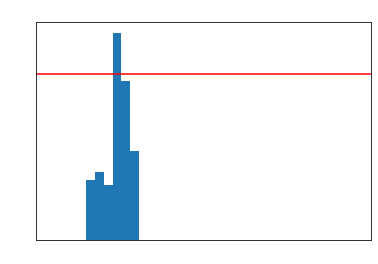

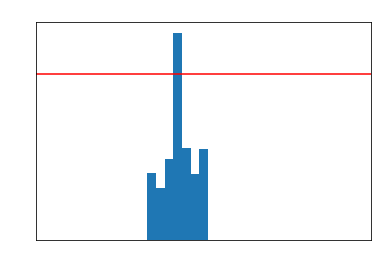

In [91]:
rr, cc = np.where(even_better_keypoints)

for r, c in zip(rr,cc):
    mag_around_point = mag[r-1:r+2,c-1:c+2]
    orientation_around_point = orientation[r-1:r+2,c-1:c+2]
    plt.figure()
    hist,bin_edges = np.histogram(np.rad2deg(orientation_around_point.ravel())+180,bins=np.arange(0,360,10),weights=mag_around_point.ravel())
    plt.bar(bin_edges[:-1], hist, width = 10)
    plt.title("Orientation for point row: {} column: {}".format(r,c))
    plt.axhline(0.8*np.max(hist),color='red')

In [92]:
rr, cc = np.where(even_better_keypoints)
descriptors  = list()
for r, c in zip(rr,cc):
    mag_around_point = mag[r-8:r+8,c-8:c+8]
    orientation_around_point = orientation[r-8:r+8,c-8:c+8]
    point_descriptor =  np.zeros(shape=(16,8))
    it = 0
    for x in np.arange(0,16,4):
        for y in np.arange(0,16,4):
            local_orientation = orientation_around_point[y:y+4,x:x+4]
            local_mag = mag_around_point[y:y+4,x:x+4]
            hist,bin_edges = np.histogram(np.rad2deg(local_orientation.ravel())+180,
                                          bins=np.linspace(0,360,9),
                                          weights=local_mag.ravel())
            point_descriptor[it,:] = hist
            it=it+1

    descriptors+=[list(point_descriptor)]



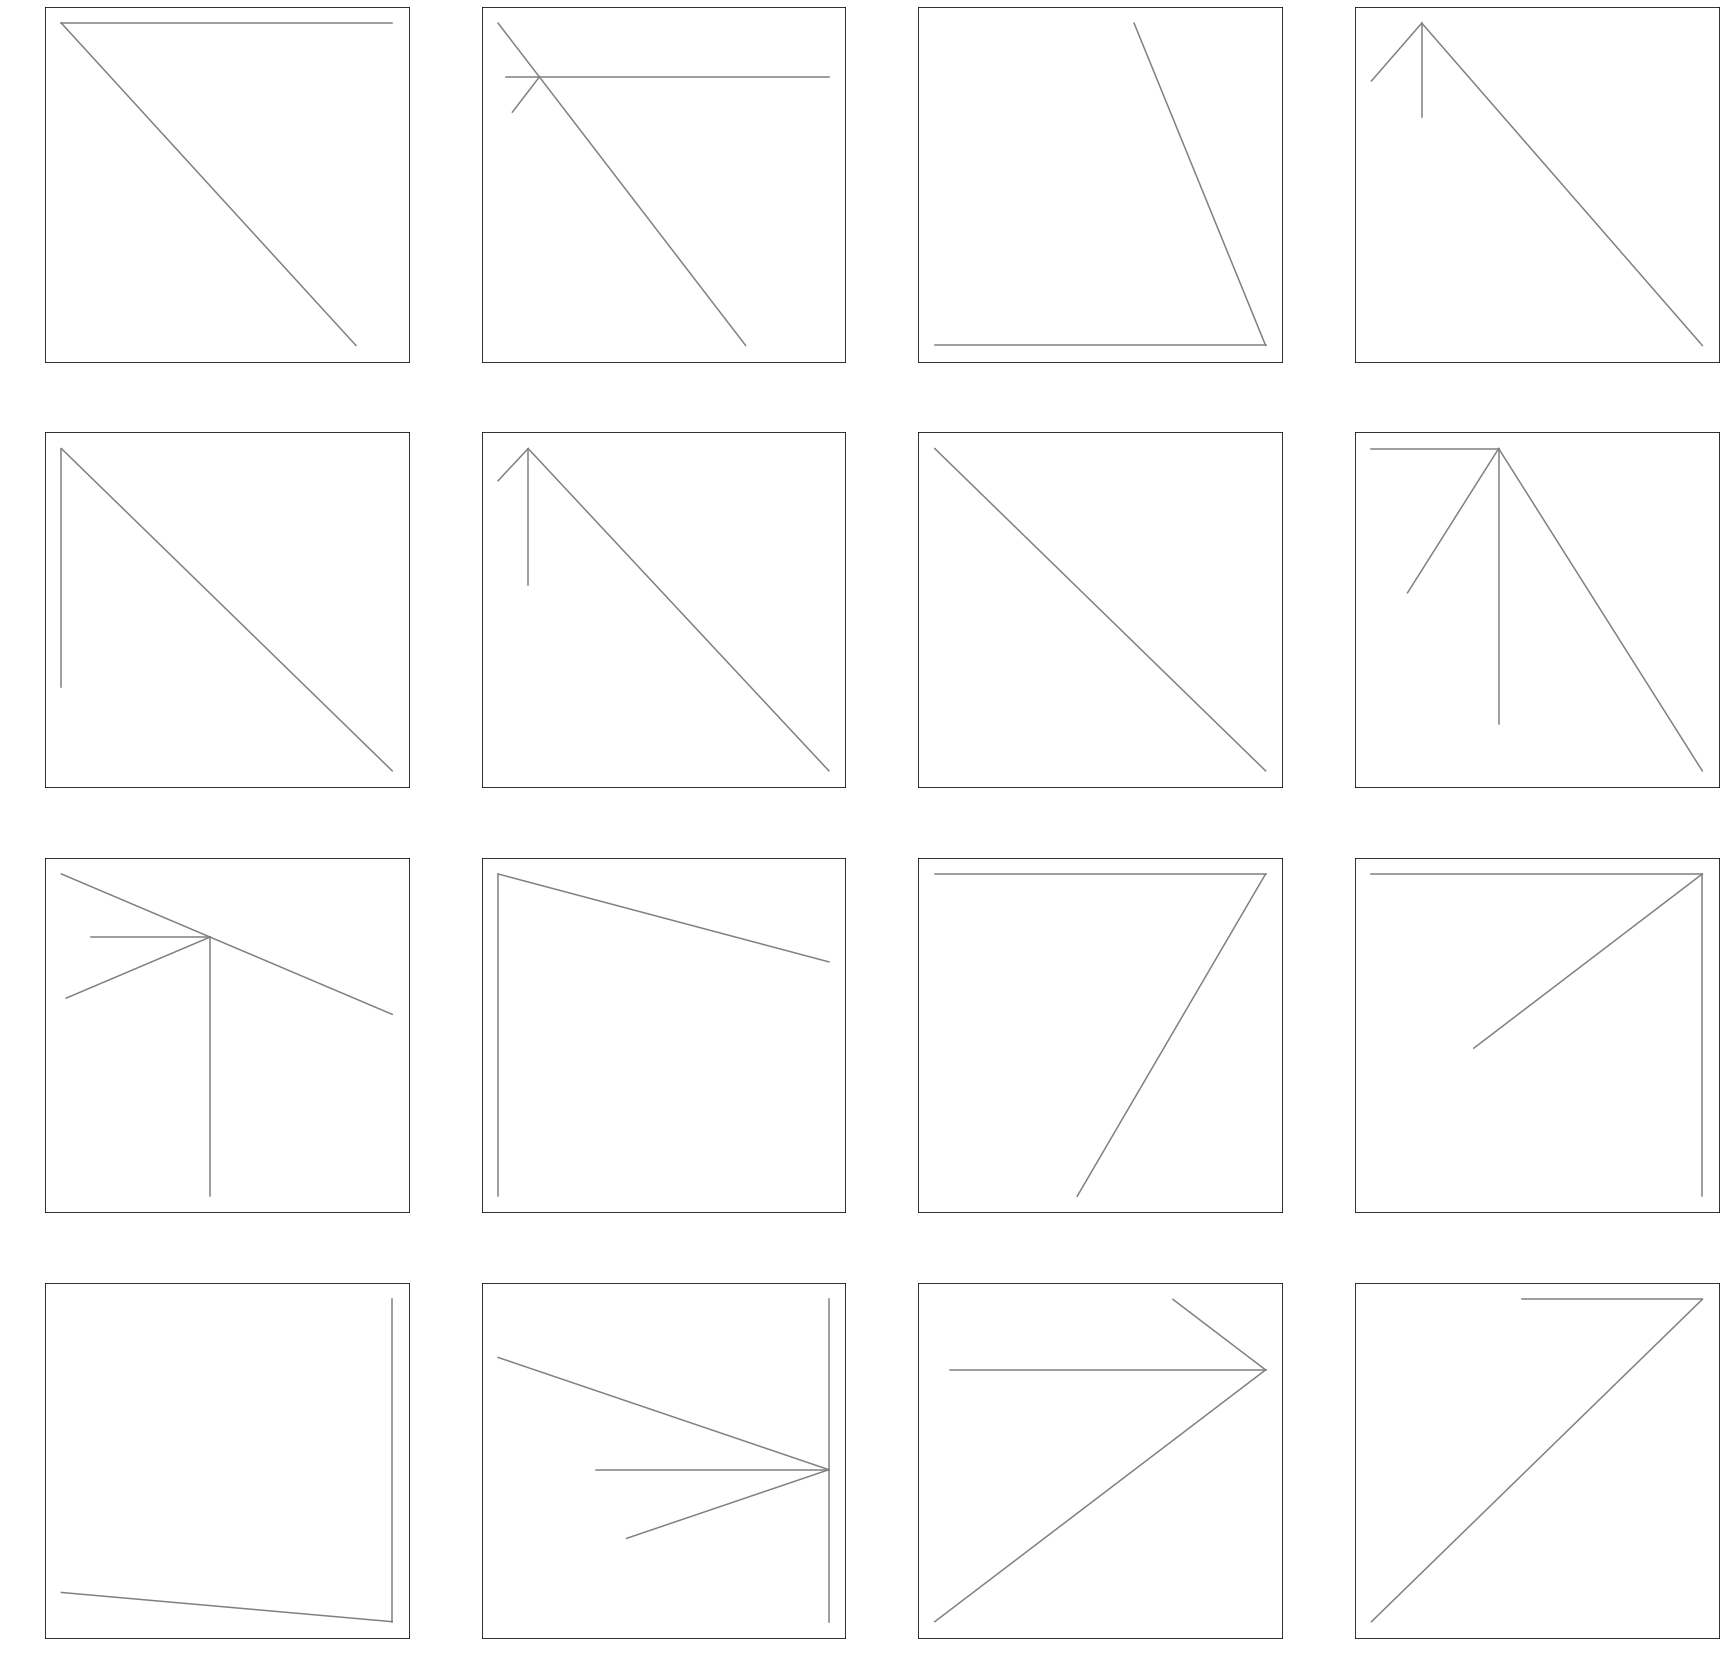

In [119]:
theta = np.linspace(0, 360, 9)
it = 0
fig, axs = plt.subplots(4, 4)
fig.set_size_inches((30,30))
descriptor  = descriptors[5]
for x in range(16):
    panel = descriptor[x]
    for i in range(len(panel)):

        r = np.sqrt(panel[i]) # circle radius

        x1 = r * np.cos(np.deg2rad(theta[i]))
        x2 = r * np.sin(np.deg2rad(theta[i]))

        axs[x//4,x%4].plot((0, x1), (0, x2), color='gray')